We model a region of pixel intensities using the multivariate normal distribution. We begin by making a maximum likelihood fit of a normal distribution to the cracked/uncracked pixels.

$$
\text{Pr}(\mathbf{x}|w = k) = \text{Norm}_{\mathbf{x}}(\mu_k, \Sigma_k)
$$

$$
    \hat{\Sigma} = \frac{1}{I}\sum_{i = 1}^{I}(\mathbf{x}_i - \mu_k)(\mathbf{x}_i - \mu_k)^T \quad \mathbf{x}_i \in\mathcal{S}_k
$$

$$
    \hat{\mu}_k = \frac{1}{I}\sum_{i=1}^I\mathbf{x}_i \quad \mathbf{x}_i \in \mathcal{S}_k
$$

Where $I$ is the number of datapoints in the set of pixels $\mathcal{S}_k$ of class $k$ (i.e. cracked/uncracked).

For inference, we use a Bernoulli prior. The parameter of this prior is sigmoidal mapping of a linear function in the neighborhood's maximum likelihood crack probability densities $\text{Pr}(\mathbf{x}|w = k)$.
$$
    \text{Pr}(w = k|\mathcal{S}_N) = \lambda_k = \frac{1}{1 + \exp[\phi^T p_{N}])}
$$
where $p_N$ is the vector of neighboring crack probabilities:
$$
    p_N =  \begin{bmatrix}
                \text{Pr}_{x_{N1}}(w = 1 \ | \ \mathcal{S}_{N1})\\
                \vdots \\
                \text{Pr}_{x_{NN}}(w = 1 \ | \ \mathcal{S}_{NN})
           \end{bmatrix} 
$$

and $\mathcal{S_{N1}}$ is the set of neighboring pixels for the first neighboring pixel of the current pixel (yikes get some notation).

Now, each step of posterior inference is:

$$
\text{Pr}(w = k|\mathcal{S}_n) \quad \propto \quad \text{Pr}(\mathbf{x} \ | \ w = k, \mathcal{S}_N) \cdot \text{Pr}(w = k \ | \ p_N)
$$

In [145]:
import matplotlib.pyplot as plt
from skimage import morphology
from scipy.misc import imread
import numpy as np
import pickle
from tqdm import tqdm
import glob

%matplotlib inline

In [121]:
def data_is_aligned(image_filepaths, mask_filepaths):
    image_ids = [s.split('\\')[-1][:-4] for s in image_filepaths]
    mask_ids = [s.split('\\')[-1][:-4] for s in mask_filepaths]
    return mask_ids == image_ids

# Import images
image_filepaths = glob.glob('.\\data\\resized-images\*.png')
mask_filepaths  = glob.glob('.\\data\\annotated-images-masks\\*.png')
images      = np.array([imread(fp) for fp in image_filepaths])
masks     = np.array([imread(fp) for fp in mask_filepaths])

assert data_is_aligned(image_filepaths, mask_filepaths)

In [ ]:
# Use description
#----------------
# 1. Feed in an image/set of pixels to classifier.
# 2. Classifier evaluates the probability that each pixel corresponds to a crack.
# 3. Classifier returns a heatmap of crack probabilities.

# Model detail
#--------------
# 2.1. Classifier evaluates the likelihood that a pixel was drawn from the crack distribution using the normal. (fixed probabilities)
# 2.2. Classifier sets initial priors equal to (a) base rate, (b) 0.5
# 2.3. Classifier loops over all pixels:
#    2.3.1. Collects the adjacent pixel 'crack' probabilities.
#    2.3.2. Fits the gradient parameter across all pixels using maximum likelihood.
#    2.3.3. Computes each pixel's updated prior based on this fit.
#    2.3.4. Computes the new posterior class membership probability.
#    2.3.5. Iteration stops when the probabilities stop changing.
# 2.4. Return the image of pixel membership probabilities.

# Other Stuff
#--------------
# - Neighborhood morphology.
# - Is it necessary to update the gradient parameters each time?
# - What update pattern encourages most rapid convergence?
# - How do the class priors affect convergence?
# - Do other distributions for the likelihood/prior result in a better fit?
# - Is it optimal to use the same morphology for the pixel intensities as for the pixel probabilities?

# An animation would be nice!

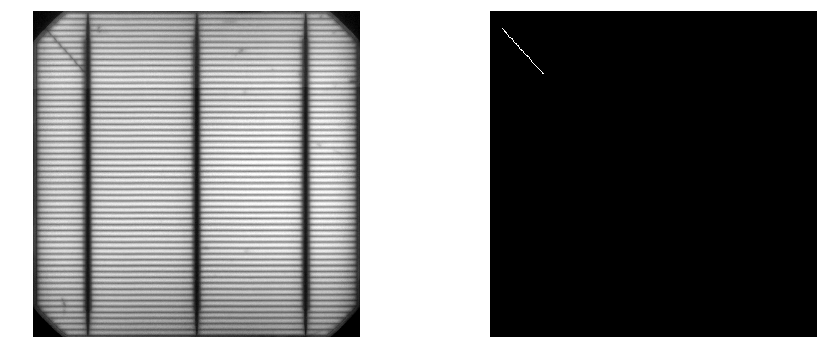

In [122]:
# Display images from
f, axs = plt.subplots(1, 2, figsize = (15, 6))
axs[0].imshow(images[0], cmap = 'gray'); axs[0].axis('off')
axs[1].imshow(masks[0], cmap = 'gray'); axs[1].axis('off');

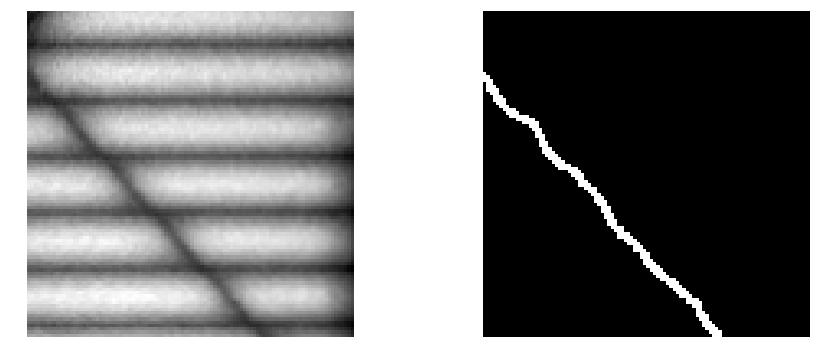

In [123]:
# How big's that crack?
f, axs = plt.subplots(1, 2, figsize = (15, 6))
axs[0].imshow(images[0][50:150, 50:150], cmap = 'gray'); axs[0].axis('off')
axs[1].imshow(masks[0][50:150, 50:150], cmap = 'gray'); axs[1].axis('off');

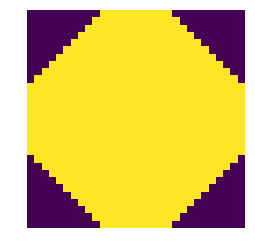

In [56]:
plt.imshow(morphology.octagon(10, 10)); plt.axis('off');

In [136]:
def hadamard_kernel(image, ix_c, kernel):
    # Returns the hadamard product of the kernel with the image, centered on (ix_c[0], ix_c[1])
    k_w          = kernel.shape[1]  # Kernel width
    k_h          = kernel.shape[0]  # Kernel height
    image        = np.pad(image, [[k_h, k_h], [k_w, k_w]], mode = 'constant', constant_values = 0)
    image_window = image[ix_c[0] + k_h - np.floor(k_h/2).astype(int) : ix_c[0] + k_h + np.ceil(k_h/2).astype(int),
                         ix_c[1] + k_w - np.floor(k_w/2).astype(int) : ix_c[1] + k_w + np.ceil(k_w/2).astype(int)]
    return image_window*kernel

In [162]:
# Classifier evaluates the likelihood that a pixel was from a normal distribution of cracked pixel intensities.
# -> Fit a normal distribution for crack intensities.

# How to describe the neighborhood?
pixel_kernel = morphology.octagon(10, 10)
img_shape    = images[0, :, :].shape
n_rows       = images.shape[0]*int(img_shape[0]*img_shape[1]*0.005)
n_features   = pixel_kernel.shape[0]*pixel_kernel.shape[1]
crack_px_vectors = np.zeros([n_rows, n_features])# Assume < 1% of pixels in an image are cracked

# Loop over all masks
ix = 0
for img_ix in tqdm(range(masks.shape[0])): # For each image
    image         = images[img_ix]
    crack_indices = np.nonzero(masks[img_ix] != 0)
    for px_c in zip(crack_indices[0], crack_indices[1]): # For each cracked pixel in that image
        crack_px_vectors[ix, :] = hadamard_kernel(image, px_c, pixel_kernel).flatten()
        ix += 1
        
crack_px_vectors = crack_px_vectors[np.any(crack_px_vectors != 0, axis = 1)]
print('Pixel neighborhood vectors created successfully.')

100%|██████████████████████████████████████████| 52/52 [00:40<00:00,  1.15it/s]


Pixel neighborhood vectors created successfully.


In [168]:
# Now calculate the multivariate mean and covariance matrix for each of these pixel neighborhoods
params = {'mu': 0, 'Sigma': 0}

# We take the maximum likelihood values (full covariance matrix)
params['mu']    = np.mean(crack_px_vectors, axis = 0)
params['Sigma'] = np.mat(crack_px_vectors - params['mu'].T).T * np.mat(crack_px_vectors - params['mu'].T)/crack_px_vectors.shape[0]

The multivariate normal distribution should describe a crack. Let's take a look at the average crack pixel neighborhood.

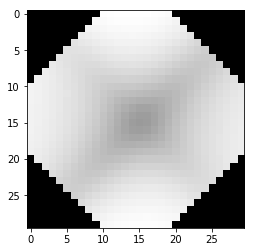

In [180]:
plt.imshow(params['mu'].reshape(pixel_kernel.shape), cmap = 'gray');

Now what we need to do is to set up the neighborhood probability density calculations